In [0]:
%tensorflow_version 2.x # selecting tensorflow version

!sudo pip install --upgrade pip;
!sudo pip install --upgrade tensorflow;

## Στοιχεία Ομάδας

Αριθμός Ομάδας: Μ.Α.11

    > Καρυπιάδης Ευστράτιος: 03114911

---

## Σύνολο Δεδομένων CIFAR-100

Το σύνολο δεδομένων στο οποίο θα εργαστούμε είναι το [CIFAR-100](https://bit.ly/38CUquZ), το οποίο αποτελείται απο 60.000 έγχρωμες εικόνες διαστάσεων 32x32. Κάθε μία από αυτές ανήκει σε μία γενική(*fine*) και μία ειδική(*coarse*) κατηγορία του συνόλου, πλήθους 100 και 20 αντίστοιχα. Προς ταξινόμηση των δειγμάτων μας θα εκμεταλευτούμε μονάχα τις *fine* κατηγορίες των εικόνων που έχουμε στη διάθεσή μας.

	

### Εισαγωγή συνόλου δεδομένων

In [0]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# loading the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

Για τους σκοπούς της άσκησης **δε** θα εκμεταλλευτούμε ολόκληρο το σύνολο δεδομένων, αλλά θα δουλέψουμε σε ένα υποσύνολο αυτού σύμφώνα με τον αύξοντα αριθμό της ομάδας μας, `team_seed`. Στη συνέχεια υλοποιούμε μία σειρά βοηθητικών συναρτήσεων που θα μας βοηθήσουν σε αυτόν το διαχωρισμό:

In [0]:
def select_from_list(from_list, index_list):
  """ Return from_list elemenents according to index contained in index_list. """
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

def get_ds_index(unfiliterd_list, target_list):
  """ Append in filtered_list the index of each element in unfiltered_list if it exists in target_list. """
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

def select_classes_number(classes_number = 20):
  """ Select unique subset of CIFAR-100 with classes_number of classes. """
  if classes_number == 20:
    return "https://bit.ly/3b3Cewb"
  elif classes_number == 40:
    return "https://bit.ly/3aPo819"
  elif classes_number == 60:
    return "https://bit.ly/2Wbo47K"
  elif classes_number == 80:
    return "https://bit.ly/38NDW3d"
  else:
    return -1

### Διαχωρισμός δεδομένων εκπαίδευσης - ελέγχου

Στο επόμενο κελί επιλέγουμε το πλήθος των κατηγοριών με το οποίο επιθυμούμε να δουλέψουμε:

In [0]:
cifar100_classes_url = select_classes_number(classes_number=80) # default: 20 classes

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [0]:
team_seed = 11 # team_seed number

team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None) # fetch class indexes
CIFAR100_LABELS_LIST = pd.read_csv("https://bit.ly/3cRO3qZ", sep=',', header=None).astype(str).values.tolist()[0] # fetch class names

our_index = team_classes.iloc[team_seed, :].values.tolist() # select team class indices
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index) # select team class names

train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

# Train data and labels
x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))

# Test data and labels
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

Μετά την παραπάνω διαδικασία εμφανίζουμε τα ονόματα των κατηγοριών που αντιστοιχούν στην ομάδα μας:

In [6]:
print(our_classes)

['apple', ' baby', ' bear', ' bed', ' bee', ' beetle', ' bicycle', ' bottle', ' boy', ' bridge', ' bus', ' camel', ' caterpillar', ' chimpanzee', ' clock', ' cockroach', ' couch', ' crab', ' cup', ' dinosaur', ' dolphin', ' flatfish', ' forest', ' girl', ' hamster', ' house', ' kangaroo', ' lawn_mower', ' leopard', ' lion', ' lizard', ' lobster', ' man', ' maple_tree', ' motorcycle', ' mountain', ' mouse', ' mushroom', ' oak_tree', ' orange', ' otter', ' palm_tree', ' pear', ' pickup_truck', ' pine_tree', ' plain', ' poppy', ' porcupine', ' possum', ' rabbit', ' raccoon', ' ray', ' rocket', ' rose', ' sea', ' seal', ' shark', ' shrew', ' skunk', ' skyscraper', ' snail', ' snake', ' spider', ' squirrel', ' streetcar', ' sunflower', ' sweet_pepper', ' tank', ' telephone', ' television', ' tiger', ' tractor', ' train', ' tulip', ' turtle', ' wardrobe', ' whale', ' willow_tree', ' woman', ' worm']


### Επισκόπηση δεδομένων και κανονικοποίηση

Τέλος, για καλύτερη εποπτεία του συνόλου δεδομένων μας θα εξάγουμε ορισμένες χρήσιμες πληροφορίες για αυτό, ενώ παράλληλα θα κανονικοποιήσουμε τις τιμές αναπαράστασης των εικόνων:

In [7]:
data_size, img_rows, img_cols, img_channels = x_train_ds.shape # get train dataset dimensions

# Set validation set percentage
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# Summarize loaded dataset
print('Train:       X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation:  X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test:        X=%s, y=%s' % (x_test.shape, y_test.shape))

Train:       X=(34000, 32, 32, 3), y=(34000, 1)
Validation:  X=(6000, 32, 32, 3), y=(6000, 1)
Test:        X=(8000, 32, 32, 3), y=(8000, 1)


---

## Συναρτήσεις Προετοιμασίας Δεδομένων και Οπτικοποίησης Απόδοσης

Στη συνέχεια θα υλοποιήσουμε απαραίτητες συναρτήσεις προετοιμασίας των δεδομένων για εκπαίδευση, καθώς και οπτικοποίσης της τελικής απόδοσης των μοντέλων που πρόκειται να δοκιμάσουμε.

### Συναρτήσεις Εκπαίδευσης

Αρχικά θα υλοποιήσουμε την `_input_fn`, η οποία αποτελεί ένα *pipeline* που θα προετοιμάσει τα δεδομένα μας για την εκπαίδευση. Πιο συγκεκριμένα, χρησιμοποιούμε τις μεθόδους `shuffle`, `repeat` και `batch` της [tf.data.Dataset](https://bit.ly/2vk7EPr), ώστε να δημιουργήσουμε υποσύνολα 128 δειγμάτων, τα οποία ελήφθησαν τυχαίως από το ολικό μας σύνολο. Σημειώνουμε ότι η μέθοδος `repeat` είναι απαραίτητη για να αντιμετωπίσουμε τυχόν σφάλμα που θα προκύψει, εάν η μέθοδος `batch` επιχειρήσει να δημιουργήσει εκ νέου υποσύνολο, αφού έχει ομαδοποιήσει όλα τα διαθέσιμα δείγματα του συνόλου. 

Παρατηρούμε ότι η συνάρτηση επιστρέφει υποσύνολα δεδομένων `PrefetchDataset Objects`, μορφή η οποία επιταχύνει τη διαδικασία εκπαίδευσης, καθώς επιτρέπει το διάβασμα του επόμενου *batch* δεδομένων, ενώ παράλληλα εκπαιδεύεται το παρόν.

In [0]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

def _input_fn(x, y, BATCH_SIZE):
  """ Returns shuffled and batched tensors in the form of PrefetchDataset objects. """
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat() # repeat indefinately
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# PrefetchDataset objects
train_ds =_input_fn(x_train, y_train, BATCH_SIZE)
validation_ds =_input_fn(x_val, y_val, BATCH_SIZE)
test_ds =_input_fn(x_test, y_test, BATCH_SIZE)

Στη συνέχεια υλοποιούμε τη συνάρτηση `train_model`. Σημειώνουμε ότι με την παράμετρο `steps_per_epoch` μπορούμε να επιλέξουμε το πλήθος των *batches* στο οποίο επιθυμούμε να εκπαιδευτεί το μοντέλο μας πριν περάσει στην επόμενη εποχή.

In [0]:
def train_model(model, epochs):
  """ Training function. """
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=x_train.shape[0]//BATCH_SIZE, validation_data=validation_ds, validation_steps=x_val.shape[0]//BATCH_SIZE)
  return(history)

### Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

Τέλος, υλοποιούμε συναρτήσεις οπτικοποίησης της απόδοσης της εκπαίδευσης προς εξαγωγή χρήσιμων πληροφοριών και μελέτη των αποτελεσμάτων που θα προκύψουν από τη δοκιμή των μοντέλων μας.

In [0]:
def summarize_diagnostics(history):
	""" Plot diagnostic learning curves. """
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
def model_evaluation(model, evaluation_steps):
	""" Print test set and evaluation metrics. """
	print('\nTest set evaluation metrics')
	loss0, accuracy0 = model.evaluate(test_ds, steps=x_test.shape[0]//BATCH_SIZE)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps)

## Μοντέλα δικτύων

Για τους σκοπούς της άσκησης θα ακολουθήσουμε δύο μεθόδους δημιουργίας μοντέλου ταξινόμησης. Κατά τον πρώτο θα επιχειρήσουμε να υλοποιήσουμε *from-scratch* ένα συνελικτικό νευρωνικό δίκτυο, ενώ κατά το δεύτερο θα ακολουθήσουμε τη μεθοδολογία του *transfer-learning*. 

### From-scratch Convolutional Neural Network

Θα υλοποιήσουμε δύο νεωρικά δίκτυα που χαρακτηρίζονται από την ίδια αρχιτεκτονική, μεταβάλλοντας μονάχα τον αλγόριθμο βελτιστοποίησης, για να μελετήσουμε τυχόν διαφορές στην απόδοση του μοντέλου μας. Πιο συγκεκριμένα θα εξετάσουμε τους αλγόριθμους [Adam](https://bit.ly/2U98wjx) και [RMSprop](https://bit.ly/2UtfXku).

In [0]:
def init_adam_model(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.10))

  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.50))
 
  model.add(layers.Flatten())
  
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary: 
    model.summary()
  return model

def init_rmsprop_model(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.10))

  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.50))
 
  model.add(layers.Flatten())
  
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.RMSprop(lr=0.0001, decay=1e-6), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary: 
    model.summary()
  return model

Θα ξεκινήσουμε με την εκπαίδευση του δικτύου με αλγόριθμο βελτιστοποίσης *Adam* για διάρκεια 100 εποχών:

In [0]:
ADAM_MODEL_NOAUG = init_adam_model(summary=True)

ADAM_MODEL_NOAUG_history = train_model(ADAM_MODEL_NOAUG, 100)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 256)        

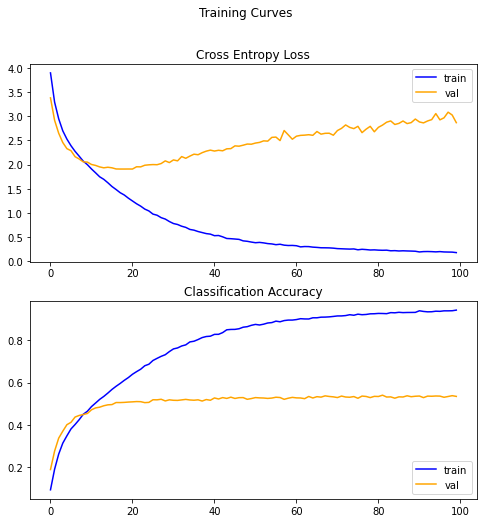


Test set evaluation metrics
125/125 [==============================] - 1s 9ms/step - loss: 2.7673 - accuracy: 0.5394
loss: 2.77
accuracy: 0.54


In [0]:
model_report(ADAM_MODEL_NOAUG, ADAM_MODEL_NOAUG.history)

Συνεχίζουμε με την εκπαίδευση του δικτύου με αλγόριθμο βελτιστοποίησης *RMSprop* και πάλι για 100 εποχές:

In [0]:
RMSPROP_MODEL_NOAUG = init_rmsprop_model(summary=True)

RMSPROP_MODEL_NOAUG_history = train_model(RMSPROP_MODEL_NOAUG, 100)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 256)        

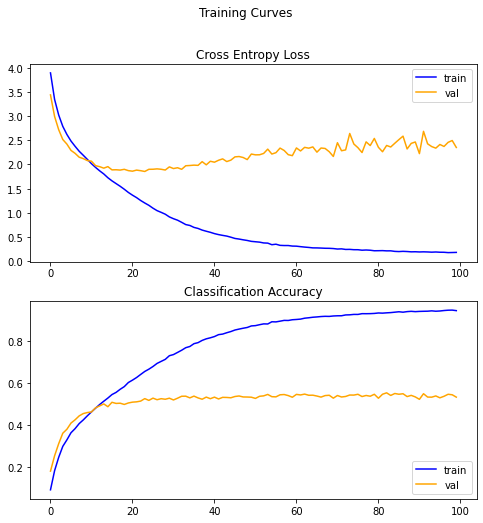


Test set evaluation metrics
125/125 [==============================] - 1s 8ms/step - loss: 2.2819 - accuracy: 0.5445
loss: 2.28
accuracy: 0.54


In [0]:
model_report(RMSPROP_MODEL_NOAUG, RMSPROP_MODEL_NOAUG.history)

Παρατηρούμε ότι το δεύτερο μοντέλο μας παρουσιάζει ελαφρώς καλύτερη απόδοση από το πρώτο. Προτού αποφανθούμε ωστόσο για την επιλογή του βέλτιστου δικτύου, θα εξετάσουμε τα παραπάνω μοντέλα εμπλουτισμένα με τη μέθοσο του [Data Augmentation](https://bit.ly/33J4ku8).

#### Data Augmentation

Θα εξετάσουμε τη μέθοδο εμπλουτισμού του συνόλου δεδομέων μας με μετασχηματισμένες εικόνες εισόδου, προκειμένου να βελτιώσουμε τη συνολική απόδοση των δικτύων μας, αλλά και για να αντιμετωπίσουμε το πρόβλημα της υπερ-εκπαίδευσης στα δεδομένα εκπαίδευσης που παρατηρούμε στα παραπάνω διαγράμματα.

Για το σκοπό αυτό θα χρησιμοποιήσουμε τον [ImageDataGenerator](https://bit.ly/33B1reJ), από τον οποίο θα επιλέξουμε τους μετασχηματισμούς `rotation_range`, `width_shift_range`, `height_shift_range` και `horizontal_flip`.

In [0]:
datagen = ImageDataGenerator(rotation_range=0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

datagen.fit(x_train)

Εξετάζουμε αρχικά το δίκτυο με αλγόριθμο ενεργοποίησης *Adam*:

In [0]:
ADAM_MODEL_AUG = init_adam_model(summary = True)

ADAM_MODEL_AUG.fit(datagen.flow(x_train, y_train, batch_size=64), steps_per_epoch=x_train.shape[0]//64, epochs=100, validation_data=(x_val, y_val))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 256)        

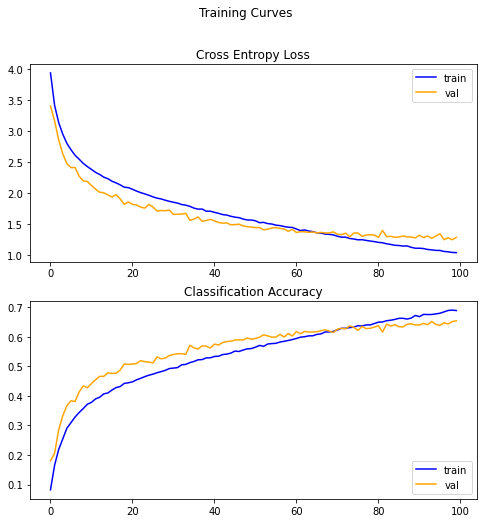


Test set evaluation metrics
125/125 [==============================] - 1s 10ms/step - loss: 1.2493 - accuracy: 0.6579
loss: 1.25
accuracy: 0.66


In [0]:
model_report(ADAM_MODEL_AUG, ADAM_MODEL_AUG.history)

Συνεχίζουμε με αλγόριθμο βελτιστοποίησης *RMSprop*:

In [0]:
RMSPROP_MODEL_AUG = init_rmsprop_model(summary = True)

RMSPROP_MODEL_AUG.fit(datagen.flow(x_train, y_train, batch_size=64), steps_per_epoch=x_train.shape[0]//64, epochs=100, validation_data=(x_val, y_val))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 256)        

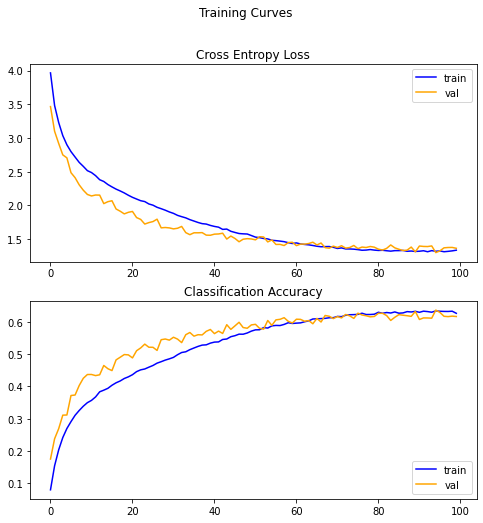


Test set evaluation metrics
125/125 [==============================] - 2s 16ms/step - loss: 1.3494 - accuracy: 0.6235
loss: 1.35
accuracy: 0.62


In [0]:
model_report(RMSPROP_MODEL_AUG, RMSPROP_MODEL_AUG.history)

Από τα παραπάνω παρατηρούμε ότι αυτή τη φορά το πρώτο μας μοντέλο ήταν αισθήτα αποδοτικότερο από το δεύτερο και μάλιστα χαρακτηρίζεται από την τάση περαιτέρω βελτίωσης. Για το λόγο αυτό το επιλέγουμε ως το τελικό μας μοντέλο, το οποίο θα εκπαιδεύσουμε, αυτή τη φορά για μεγαλύτερο χρονικό διάστημα:

In [0]:
ADAM_MODEL_AUG = init_adam_model(summary = True)

ADAM_MODEL_AUG.fit(datagen.flow(x_train, y_train, batch_size=64), steps_per_epoch=x_train.shape[0]//64, epochs=200, validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 256)        

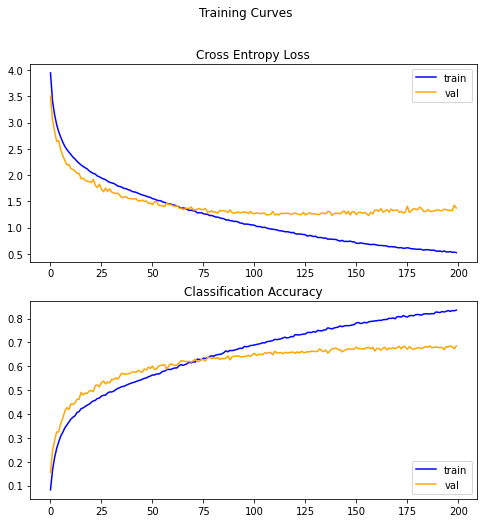


Test set evaluation metrics
125/125 [==============================] - 1s 9ms/step - loss: 1.3400 - accuracy: 0.6874
loss: 1.34
accuracy: 0.69


In [0]:
model_report(ADAM_MODEL_AUG, ADAM_MODEL_AUG.history)

Όπως ανεμέναμε το δίκτυο μας κατάφερε να βελτιώση την απόδοση του με μεγαλύτερο πλήθος εποχών. Παρόλα αυτά αξίζει να παρατηρήσουμε ότι ξεκινά και πάλι να δημιουργείται πρόβλημα υπερ-εκπαίδευσης στα δεδομένα εισόδου.

Η τελική ακρίβεια που επιτύχαμε με το δίκτυό μας είναι ίση με 70% περίπου, ενώ ο δείκτης απώλειας είναι ίσος με 1.34.

### Transfer Learning

Για τη μέθοδο της μεταφοράς μάθησης θα χρησιμοποιήσουμε το δίκτυο [VGG19](https://bit.ly/3dicnCq), για την εκπαίδευση του οποίου θα πειραματιστούμε με το όρισμα `model.trainable`. Σημειώνουμε ότι και για τις δύο μεθόδους θα κάνουμε χρήση του `ImageDataGenerator`, όπως είδαμε παραπάνω.

In [0]:
def preprocess_image(image):
  image = tf.image.resize(image, [224, 224])
  return image

def _new_input_fn(x, y, BATCH_SIZE):
  """ Returns shuffled and batched tensors in the form of PrefetchDataset objects. """
  x_ds = tf.data.Dataset.from_tensor_slices((x))
  x_ds = x_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
  y_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y, tf.int64))
  ds = tf.data.Dataset.zip((x_ds, y_ds))

  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat() # repeat indefinately
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# PrefetchDataset objects
new_train_ds =_new_input_fn(x_train, y_train, BATCH_SIZE)
new_validation_ds =_new_input_fn(x_val, y_val, BATCH_SIZE)
new_test_ds =_new_input_fn(x_test, y_test, BATCH_SIZE)

Θα ξεκινήσουμε με όρισμα `trainable=False`:

In [0]:
def init_VGG19_model(summary):

  VGG19_MODEL=tf.keras.applications.VGG19(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  VGG19_MODEL.trainable=False

  flatten_layer = tf.keras.layers.Flatten()
  dense_layer = tf.keras.layers.Dense(1024, activation='elu')
  dropout_layer = tf.keras.layers.Dropout(rate=0.50)
  prediction_layer = tf.keras.layers.Dense(100, activation='softmax')

  model = tf.keras.Sequential([VGG19_MODEL, flatten_layer, dense_layer, dropout_layer, prediction_layer])
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

  if summary: 
    model.summary()

  return model

In [14]:
VGG19_MODEL_ = init_VGG19_model(summary = True)

VGG19_MODEL_.fit(datagen.flow(x_train, y_train, batch_size=64), steps_per_epoch=x_train.shape[0]//64, epochs=50, validation_data=(x_val, y_val))

80142336/80134624 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               102500    
Total params: 20,652,196
Trainable params: 627,812
Non-trainable params: 20,024,384
_________________________________________________________________
  ...
    to  
  ['...']
Train for 531 

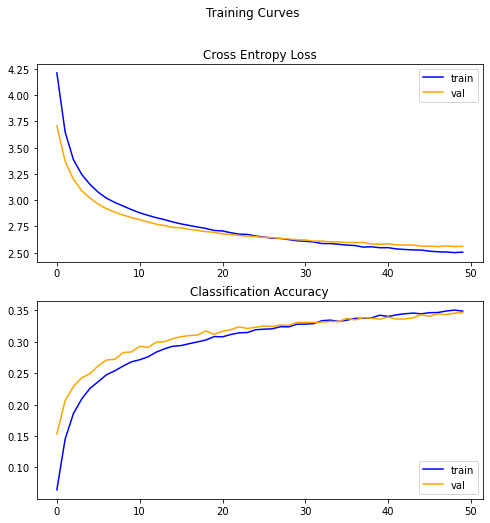


Test set evaluation metrics
125/125 [==============================] - 2s 13ms/step - loss: 2.5289 - accuracy: 0.3465
loss: 2.53
accuracy: 0.35


In [15]:
model_report(VGG19_MODEL_, VGG19_MODEL_.history)

Συνεχίζουμε με `trainable=True`:

In [0]:
def init_VGG19_model_V2(summary):

  VGG19_MODEL=tf.keras.applications.VGG19(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  VGG19_MODEL.trainable=True
  
  flatten_layer = tf.keras.layers.Flatten()
  dense_layer = tf.keras.layers.Dense(1024, activation='elu')
  dropout_layer = tf.keras.layers.Dropout(rate=0.50)
  prediction_layer = tf.keras.layers.Dense(100, activation='softmax')

  model = tf.keras.Sequential([VGG19_MODEL, flatten_layer, dense_layer, dropout_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

  if summary: 
    model.summary()

  return model

In [25]:
VGG19_MODEL_V2 = init_VGG19_model_V2(summary = True)

VGG19_MODEL_V2.fit(datagen.flow(x_train, y_train, batch_size=64), steps_per_epoch=x_train.shape[0]//64, epochs=25, validation_data=(x_val, y_val))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               102500    
Total params: 20,652,196
Trainable params: 20,652,196
Non-trainable params: 0
_________________________________________________________________
  ...
    to  
  ['...']
Train for 531 steps, validate on 6000 samples
Epoch 1/25
531/531 [=================

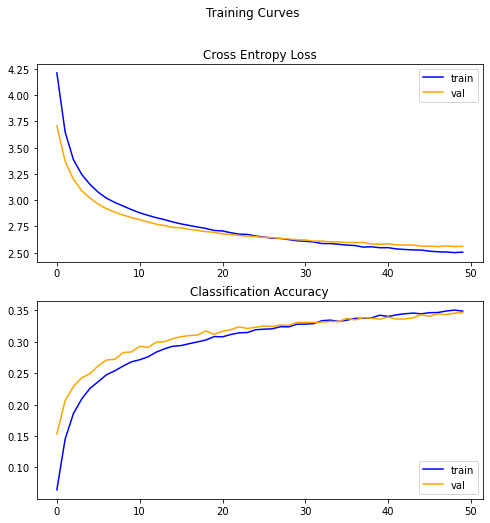


Test set evaluation metrics
125/125 [==============================] - 2s 12ms/step - loss: 1.7700 - accuracy: 0.6072
loss: 1.77
accuracy: 0.61


In [27]:
model_report(VGG19_MODEL_V2, VGG19_MODEL_.history)